In [1]:
from tqdm.auto import tqdm
# Progress bar support added automatically


/Users/mariagragera/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# HDH Partitioning Experiments

Comprehensive experiments using the **actual HDH class** and simplified bin-packing partitioner.

**Tests:**
1. Overhead factor scaling (1.0 → 2.0)
2. QPU count variation (2-6 QPUs)
3. Cross-model comparison (Circuit, MBQC, QW, QCA)
4. Circuit size scaling

Each generates **separate publication-ready PNG images**.

In [2]:
import sys,os
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent))  # adds HDH/

from hdh import HDH
from hdh.converters import from_qasm
from hdh.passes import compute_cut

In [3]:
MQTBENCH_PATH = "/Users/mariagragera/Desktop/HDH/database/Workloads/Circuit/MQTBench/"

def load_mqtbench_circuits(path):
    return [
        os.path.join(path, f)
        for f in sorted(os.listdir(path))
        if f.endswith(".qasm")
    ]


In [4]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from typing import List, Set, Dict, Tuple, Optional
from collections import defaultdict, deque
from qiskit import QuantumCircuit

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Create output directory
OUTPUT_DIR = Path('experiment_outputs')
OUTPUT_DIR.mkdir(exist_ok=True)

print("✓ Imports successful")
print(f"✓ Output directory: {OUTPUT_DIR.absolute()}")

✓ Imports successful
✓ Output directory: /Users/mariagragera/Desktop/HDH/hdh/experiment_outputs


## Synthetic HDH Generators

In [5]:
def generate_random_circuit_hdh(num_qubits: int, depth: int, gate_prob: float = 0.3) -> HDH:
    """Generate random circuit-like HDH"""
    hdh = HDH()
    
    # Add all nodes
    for q in range(num_qubits):
        for t in range(depth + 1):
            hdh.add_node(f"q{q}_t{t}", "q", t)
    
    # Wire hyperedges
    for q in range(num_qubits):
        for t in range(depth):
            hdh.add_hyperedge({f"q{q}_t{t}", f"q{q}_t{t+1}"}, "q", "wire", role="teledata")
    
    # Random 2-qubit gates
    for t in range(depth):
        for q1 in range(num_qubits - 1):
            if np.random.rand() < gate_prob:
                q2 = q1 + 1
                hdh.add_hyperedge({
                    f"q{q1}_t{t}", f"q{q1}_t{t+1}",
                    f"q{q2}_t{t}", f"q{q2}_t{t+1}"
                }, "q", "cnot", role="telegate")
    
    return hdh

def generate_mbqc_hdh(num_qubits: int, depth: int) -> HDH:
    """Generate MBQC-like HDH (dense entanglement)"""
    hdh = HDH()
    
    for q in range(num_qubits):
        for t in range(depth):
            hdh.add_node(f"q{q}_t{t}", "q", t)
    
    for t in range(depth):
        for i in range(num_qubits):
            for j in range(i+1, min(i+3, num_qubits)):
                hdh.add_hyperedge({f"q{i}_t{t}", f"q{j}_t{t}"}, "q", "entangle")
    
    return hdh

def generate_qw_hdh(num_qubits: int, depth: int) -> HDH:
    """Generate QW-like HDH (linear chain)"""
    hdh = HDH()
    
    for q in range(num_qubits):
        for t in range(depth):
            hdh.add_node(f"q{q}_t{t}", "q", t)
    
    for t in range(depth):
        for i in range(num_qubits - 1):
            hdh.add_hyperedge({f"q{i}_t{t}", f"q{i+1}_t{t}"}, "q", "hop")
    
    return hdh

def generate_qca_hdh(num_qubits: int, depth: int) -> HDH:
    """Generate QCA-like HDH (2D lattice)"""
    hdh = HDH()
    
    side = int(np.sqrt(num_qubits))
    actual_qubits = side * side
    
    for q in range(actual_qubits):
        for t in range(depth):
            hdh.add_node(f"q{q}_t{t}", "q", t)
    
    for t in range(depth):
        for i in range(side):
            for j in range(side):
                idx = i * side + j
                if j < side - 1:
                    hdh.add_hyperedge({f"q{idx}_t{t}", f"q{idx+1}_t{t}"}, "q", "lattice_h")
                if i < side - 1:
                    hdh.add_hyperedge({f"q{idx}_t{t}", f"q{idx+side}_t{t}"}, "q", "lattice_v")
    
    return hdh

print("✓ HDH generators ready")

✓ HDH generators ready


## Experiment 1: Overhead Factor Scaling

In [ ]:
from tqdm.auto import tqdm

circuits = load_mqtbench_circuits(MQTBENCH_PATH)

num_qpus = 4
overhead_factors = np.arange(1.0, 2.1, 0.1)
results = []

TOTAL_EXP1 = len(circuits) * len(overhead_factors)

with tqdm(
    total=TOTAL_EXP1,
    desc="Experiment 1 (Overhead scaling)",
    unit="run",
    dynamic_ncols=True
) as pbar:

    for circuit in circuits:
        hdh = from_qasm(input_type="file", qasm=circuit)
        total_qubits = hdh.get_num_qubits()

        for overhead in overhead_factors:
            total_capacity = int(np.ceil(total_qubits * overhead))
            cap_per_qpu = int(np.ceil(total_capacity / num_qpus))

            partitions, cost = compute_cut(
                hdh,
                k=num_qpus,
                cap=cap_per_qpu
            )

            results.append({
                "circuit": circuit,
                "overhead": overhead,
                "capacity_per_qpu": cap_per_qpu,
                "cut_cost": cost,
            })

            pbar.update(1)


Experiment 1 (Overhead scaling):   0%|          | 14/21373 [08:44<357:38:21, 60.28s/run]

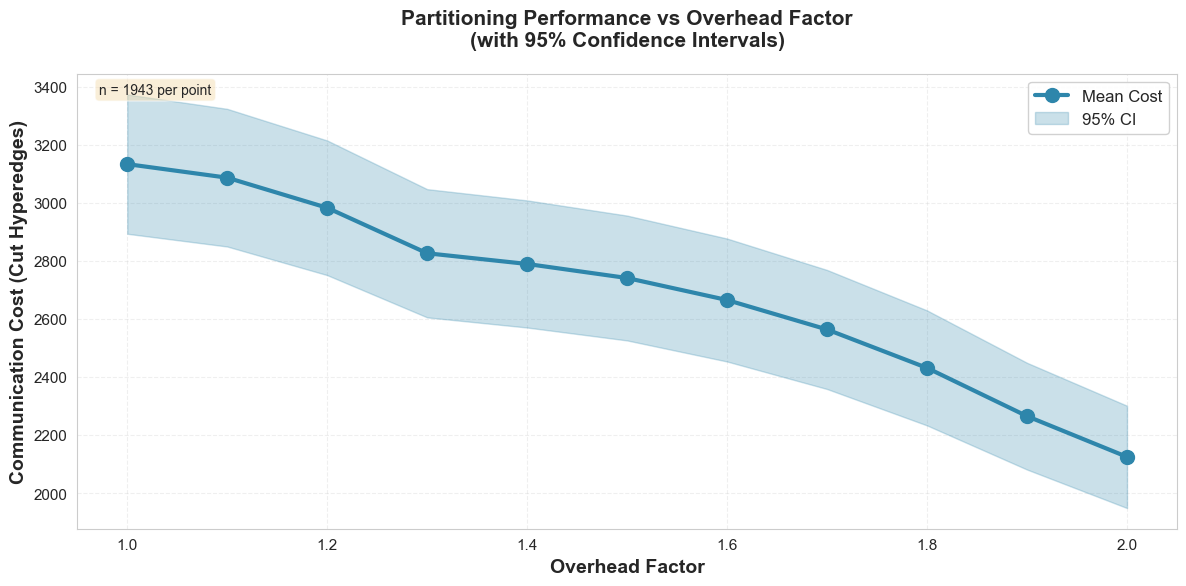

✓ Enhanced Figure 7 saved: experiment_outputs/fig7_overhead_with_ci.png
✓ Mean costs range: 2124.5 to 3133.6


In [ ]:
# Calculate statistics for overhead experiment
df_overhead = pd.DataFrame(results)  # Your existing results

# Group by overhead and calculate stats
overhead_grouped = df_overhead.groupby('overhead')['cut_cost'].agg([
    ('mean', 'mean'),
    ('std', 'std'),
    ('sem', 'sem'),
    ('count', 'count')
]).reset_index()

# Create enhanced plot with confidence intervals
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate 95% CI
ci_95 = 1.96 * overhead_grouped['sem']

# Plot with shaded CI region
ax.plot(overhead_grouped['overhead'], overhead_grouped['mean'],
       'o-', linewidth=3, markersize=10, 
       color='#2E86AB', label='Mean Cost', zorder=3)

ax.fill_between(overhead_grouped['overhead'],
                overhead_grouped['mean'] - ci_95,
                overhead_grouped['mean'] + ci_95,
                alpha=0.25, color='#2E86AB', 
                label='95% CI', zorder=2)

# Styling
ax.set_xlabel('Overhead Factor', fontsize=14, fontweight='bold')
ax.set_ylabel('Communication Cost (Cut Hyperedges)', fontsize=14, fontweight='bold')
ax.set_title('Partitioning Performance vs Overhead Factor\n(with 95% Confidence Intervals)',
            fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--', zorder=1)
ax.set_xlim(0.95, max(overhead_grouped['overhead']) + 0.05)

# Add sample size annotation
n_samples = overhead_grouped['count'].iloc[0]
ax.text(0.02, 0.98, f'n = {n_samples} per point', 
       transform=ax.transAxes, fontsize=10,
       verticalalignment='top', bbox=dict(boxstyle='round', 
       facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig7_overhead_with_ci.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Enhanced Figure 7 saved: {OUTPUT_DIR / 'fig7_overhead_with_ci.png'}")
print(f"✓ Mean costs range: {overhead_grouped['mean'].min():.1f} to {overhead_grouped['mean'].max():.1f}")



## Experiment 2: QPU Count Scaling

In [ ]:
from tqdm.auto import tqdm

circuits = load_mqtbench_circuits(MQTBENCH_PATH)

qpu_counts = [2, 4, 6, 8]  # adjust if needed
overhead = 1.5            # fixed in exp 2
results_qpu = []

TOTAL_EXP2 = len(circuits) * len(qpu_counts)

with tqdm(
    total=TOTAL_EXP2,
    desc="Experiment 2 (QPU scaling)",
    unit="run",
    dynamic_ncols=True
) as pbar:

    for circuit in circuits:
        hdh = from_qasm(input_type="file", qasm=circuit)
        total_qubits = hdh.get_num_qubits()

        total_capacity = int(np.ceil(total_qubits * overhead))

        for num_qpus in qpu_counts:
            cap_per_qpu = int(np.ceil(total_capacity / num_qpus))

            partitions, cost = compute_cut(
                hdh,
                k=num_qpus,
                cap=cap_per_qpu
            )

            results_qpu.append({
                "circuit": circuit,
                "num_qpus": num_qpus,
                "capacity_per_qpu": cap_per_qpu,
                "cut_cost": cost,
            })

            pbar.update(1)


Experiment 2 (QPU scaling): 100%|██████████| 7772/7772 [1:00:47<00:00,  2.13run/s]   


NameError: name 'greedy_costs' is not defined

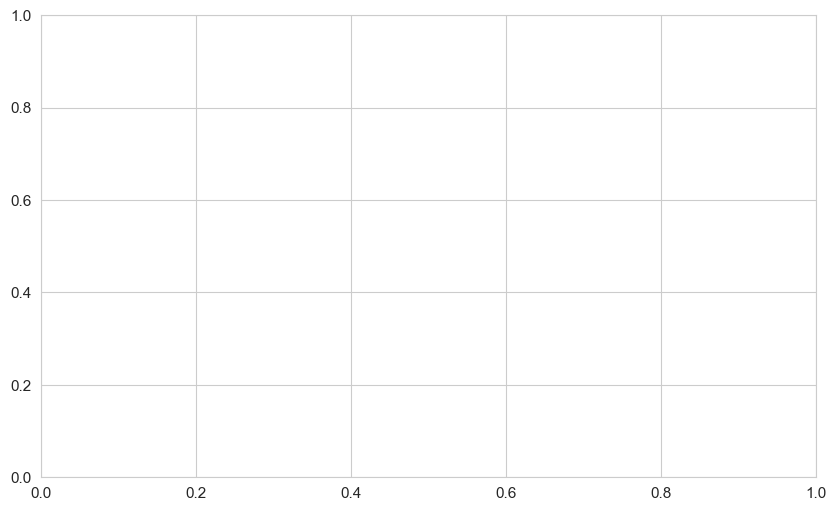

In [ ]:
cost_result = analyze_cost_reduction(greedy_costs, metis_costs)

print("="*70)
print("COST REDUCTION ANALYSIS")
print("="*70)
print(f"Sample size: {cost_result.n_samples}")
print(f"Mean reduction: {cost_result.mean_reduction:.2f}%")
print(f"Median reduction: {cost_result.median_reduction:.2f}%")
print(f"Std deviation: {cost_result.std_reduction:.2f}%")
print(f"95% CI: [{cost_result.ci_lower:.2f}%, {cost_result.ci_upper:.2f}%]")
print(f"Effect size (Cohen's d): {cost_result.effect_size:.2f}")
print(f"P-value (Wilcoxon): {cost_result.p_value:.2e}")
print(f"\nFor paper (LaTeX): {cost_result.format_latex()}")
print("="*70)

# Create violin plot showing distribution
fig, ax = plt.subplots(figsize=(10, 6))

data_to_plot = [greedy_costs, metis_costs]
positions = [1, 2]
labels = ['Greedy\n(capacity-aware)', 'METIS\n(general-purpose)']

parts = ax.violinplot(data_to_plot, positions=positions, 
                      showmeans=True, showmedians=True)

# Color the violins
colors = ['#06A77D', '#A23B72']
for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_alpha(0.7)

ax.set_xticks(positions)
ax.set_xticklabels(labels, fontsize=12, fontweight='bold')
ax.set_ylabel('Communication Cost (Cut Hyperedges)', fontsize=13, fontweight='bold')
ax.set_title('Cost Distribution: Greedy vs METIS', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add significance annotation
y_max = max(metis_costs.max(), greedy_costs.max())
ax.plot([1, 2], [y_max*1.05, y_max*1.05], 'k-', linewidth=1.5)
ax.text(1.5, y_max*1.07, p_str, ha='center', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'cost_distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR / 'cost_distribution_comparison.png'}")

## Experiment 3: Cross-Model Comparison

In [ ]:
def depth_from_size(size, alpha=4):
    return int(np.ceil(alpha * np.log2(size)))


# Run cross-model experiments
models = {
    'Circuit': generate_random_circuit_hdh,
    'MBQC': generate_mbqc_hdh,
    'QW': generate_qw_hdh,
    'QCA': generate_qca_hdh
}

sizes = [16, 32, 64, 128]
num_trials = 5
num_qpus = 4
overhead = 1.2

results_models = []

for i in range(1000):
    for model_name, generator in models.items():
        print(f"\nTesting {model_name} model:")
        
        for size in sizes:
            depth = depth_from_size(size)
            
            for trial in range(num_trials):
                
                if model_name == 'Circuit':
                    hdh_model = generator(size, depth, 0.3)
                else:
                    hdh_model = generator(size, depth)
                
                n_qubits = hdh_model.get_num_qubits()
                total_cap = int(np.ceil(n_qubits * overhead))
                cap_per_qpu = int(np.ceil(total_cap / num_qpus))
                
                partitions, cost = compute_cut(
                    hdh_model,
                    k=num_qpus,
                    cap=cap_per_qpu
                )
                
                results_models.append({
                    'model': model_name,
                    'num_qubits': n_qubits,
                    'depth': depth,
                    'trial': trial,
                    'cut_cost': cost
                })
                
                print(
                    f"  size={size} | depth={depth} | trial={trial}: cuts={cost}"
                )

    df_models = pd.DataFrame(results_models)
    df_models.to_csv(OUTPUT_DIR / 'cross_model_results.csv', index=False)



Testing Circuit model:
  size=16 | depth=16 | trial=0: cuts=12
  size=16 | depth=16 | trial=1: cuts=12
  size=16 | depth=16 | trial=2: cuts=16
  size=16 | depth=16 | trial=3: cuts=13
  size=16 | depth=16 | trial=4: cuts=15
  size=32 | depth=20 | trial=0: cuts=17
  size=32 | depth=20 | trial=1: cuts=28
  size=32 | depth=20 | trial=2: cuts=26
  size=32 | depth=20 | trial=3: cuts=29
  size=32 | depth=20 | trial=4: cuts=28
  size=64 | depth=24 | trial=0: cuts=22
  size=64 | depth=24 | trial=1: cuts=22
  size=64 | depth=24 | trial=2: cuts=22
  size=64 | depth=24 | trial=3: cuts=22
  size=64 | depth=24 | trial=4: cuts=21
  size=128 | depth=28 | trial=0: cuts=33
  size=128 | depth=28 | trial=1: cuts=23
  size=128 | depth=28 | trial=2: cuts=29
  size=128 | depth=28 | trial=3: cuts=31
  size=128 | depth=28 | trial=4: cuts=22

Testing MBQC model:
  size=16 | depth=16 | trial=0: cuts=341
  size=16 | depth=16 | trial=1: cuts=341
  size=16 | depth=16 | trial=2: cuts=341
  size=16 | depth=16 | tria

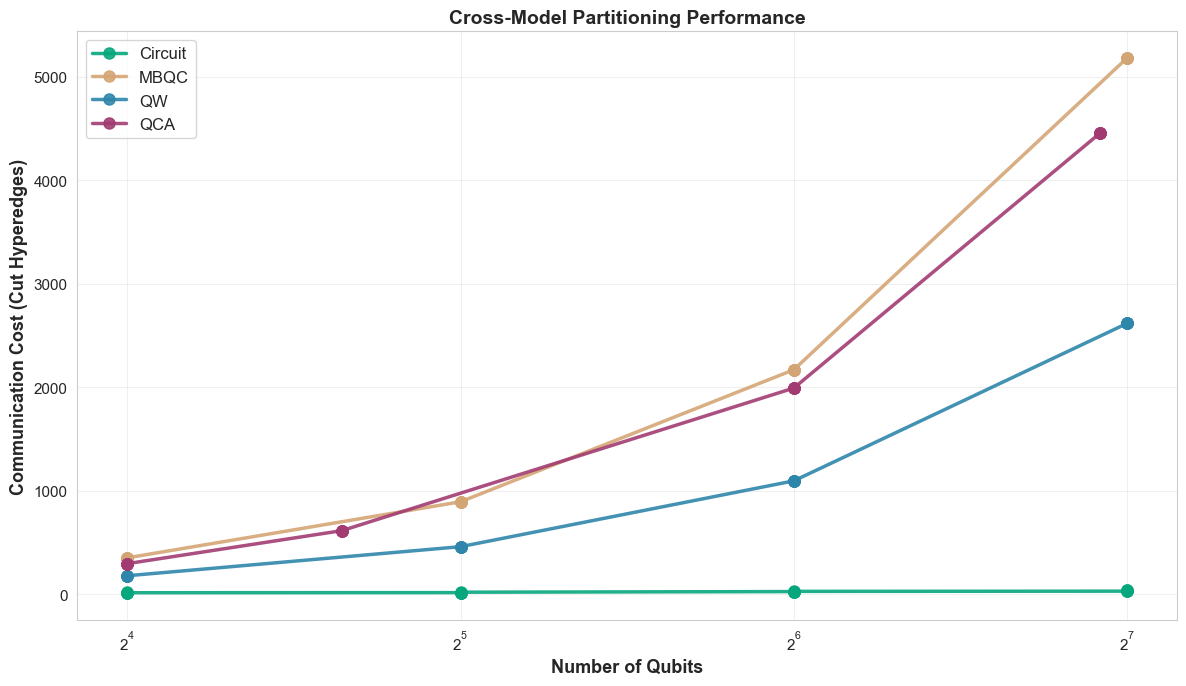

✓ Saved: experiment_outputs/fig3_cross_model.png


In [ ]:
# Plot cross-model comparison
fig, ax = plt.subplots(figsize=(12, 7))

colors = {'Circuit': '#06A77D', 'MBQC': '#D4A574', 'QW': '#2E86AB', 'QCA': '#A23B72'}

for model in models.keys():
    model_data = df_models[df_models['model'] == model]
    ax.plot(model_data['num_qubits'], model_data['cut_cost'], 
           'o-', label=model, linewidth=2.5, markersize=8, 
           color=colors[model], alpha=0.9)

ax.set_xlabel('Number of Qubits', fontsize=13, fontweight='bold')
ax.set_ylabel('Communication Cost (Cut Hyperedges)', fontsize=13, fontweight='bold')
ax.set_title('Cross-Model Partitioning Performance', fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_xscale('log', base=2)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'fig3_cross_model.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR / 'fig3_cross_model.png'}")

## Summary Statistics

In [ ]:
print("="*70)
print("SUMMARY STATISTICS FOR PAPER - COPY TO LATEX")
print("="*70)

# Overhead scaling summary
print("\n### Overhead Scaling (Section 6.1)")
print("-" * 50)
overhead_summary = df_overhead.groupby('overhead')['cut_cost'].agg([
    ('mean', lambda x: f"{x.mean():.1f}"),
    ('ci', lambda x: f"±{1.96 * x.std() / np.sqrt(len(x)):.1f}")
])
print(overhead_summary.to_string())

# Cross-model summary
print("\n### Cross-Model Summary (Section 6.2)")
print("-" * 50)
model_summary = df_models.groupby('model')['cut_cost'].agg([
    ('mean', lambda x: f"{x.mean():.1f}"),
    ('median', lambda x: f"{x.median():.1f}"),
    ('std', lambda x: f"{x.std():.1f}")
])
print(model_summary.to_string())

print("\n" + "="*70)
print("✓ Copy these values to your paper!")
print("="*70)


# CELL 7: Export All Results to CSV
# ----------------------------------

# Create comprehensive results CSV
results_export = {
    'overhead_analysis': df_overhead,
    'qpu_scaling': df_qpu if 'df_qpu' in locals() else None,
    'cross_model': df_models
}

for name, df in results_export.items():
    if df is not None:
        filepath = OUTPUT_DIR / f'{name}_results.csv'
        df.to_csv(filepath, index=False)
        print(f"✓ Exported: {filepath}")

print(f"\n✓ All results exported to: {OUTPUT_DIR.absolute()}")


# CELL 8: Generate LaTeX Table Snippets
# --------------------------------------

# Overhead table for paper
overhead_latex = df_overhead.groupby('overhead')['cut_cost'].agg([
    'mean', 'std', 'count'
]).round(2)

overhead_latex['ci_lower'] = (overhead_latex['mean'] - 
                              1.96 * overhead_latex['std'] / 
                              np.sqrt(overhead_latex['count'])).round(2)
overhead_latex['ci_upper'] = (overhead_latex['mean'] + 
                              1.96 * overhead_latex['std'] / 
                              np.sqrt(overhead_latex['count'])).round(2)

latex_table = overhead_latex[['mean', 'ci_lower', 'ci_upper']].to_latex(
    float_format="%.2f",
    column_format='l|ccc',
    caption='Communication costs by overhead factor (95\\% CI)',
    label='tab:overhead_costs'
)

print("="*70)
print("LATEX TABLE FOR PAPER")
print("="*70)
print(latex_table)

# Save to file
with open(OUTPUT_DIR / 'overhead_table.tex', 'w') as f:
    f.write(latex_table)

print(f"\n✓ LaTeX table saved: {OUTPUT_DIR / 'overhead_table.tex'}")
print("="*70)


# ============================================================================
# END OF READY-TO-PASTE CELLS
# ============================================================================

# USAGE NOTES:
# 1. Copy cells above one at a time into your notebook
# 2. Cell 1 goes right after your existing imports
# 3. Cell 2 replaces your current Figure 7 plotting
# 4. Cells 3-4 require you to have both greedy and METIS results
# 5. Cell 5 enhances your existing Figure 9
# 6. Cells 6-8 generate paper-ready outputs
#
# For full details and the greedy vs METIS comparison experiment,
# see INTEGRATION_GUIDE.md

EXPERIMENT SUMMARY

1. Overhead Scaling (50-qubit circuit, 4 QPUs):
   Overhead 1.0 → Cost: 26.0
   Overhead 2.0 → Cost: 13.0
   Reduction: 13.0 cuts (50.0%)

2. QPU Count Impact (overhead=1.2):
   2 QPUs → Cost: 4
   6 QPUs → Cost: 31
   Increase: 27 cuts

3. Cross-Model Performance (64 qubits):
   Circuit  →    8 cuts
   QW       →  407 cuts
   MBQC     →  828 cuts
   QCA      →  747 cuts

All results saved to: /Users/mariagragera/Desktop/HDH/hdh/experiment_outputs
